In [1]:
%matplotlib inline
import network.network as Network
import pickle
import matplotlib.pyplot as plt
import numpy as np

In [2]:
with open('network/trained_network.pkl', 'rb') as f:
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    net = u.load()

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/', one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/MNIST/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [4]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))

Size of:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


In [5]:
data.test.cls = np.argmax(data.test.labels, axis=1)
data.train.cls = np.argmax(data.train.labels, axis=1)

In [6]:
train_images = [np.reshape(x, (784, 1)) for x in data.train.images]
test_images = [np.reshape(x, (784, 1)) for x in data.test.images]

In [7]:
# We know that MNIST images are 28 pixels in each dimension.
img_size = 28

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1

# Number of classes, one class for each of 10 digits.
num_classes = 10

In [8]:
cls_test = data.test.cls
cls_train = data.train.cls

In [9]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Get the i'th image and reshape the array.
        image = images[i].reshape(img_shape)
        
        # Ensure the noisy pixel-values are between 0 and 1.
        image = np.clip(image, 0.0, 1.0)

        # Plot image.
        ax.imshow(image,
                  cmap='Greys', interpolation='nearest')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [10]:
def predict_noAdv(test_image):
    # Print the prediction of the network
    #print('Network output: \n' + str(np.round(net.feedforward(x), 2)) + '\n')
    return (np.argmax(net.feedforward(test_image)))

In [80]:
pred = []
total_correct = 0
for i in range(len(test_images)):
    pred.append(predict_noAdv(test_images[i]))
    if pred[i] == cls_test[i]:
        total_correct += 1
        
acc = (total_correct / (i+1)) * 100
print(acc)

87.01


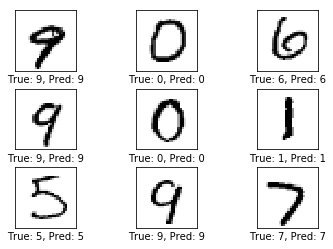

In [12]:
plot_images(images=data.test.images[9:18], cls_true=cls_test[9:18],cls_pred=pred[9:18])

In [13]:
def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))
                                                                                                                                                                                
def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))

In [14]:
def input_derivative(net, x, y):
    """ Calculate derivatives wrt the inputs"""
    nabla_b = [np.zeros(b.shape) for b in net.biases]
    nabla_w = [np.zeros(w.shape) for w in net.weights]
    
    # feedforward
    activation = x
    activations = [x] # list to store all the activations, layer by layer
    zs = [] # list to store all the z vectors, layer by layer
    for b, w in zip(net.biases, net.weights):
        z = np.dot(w, activation)+b
        zs.append(z)
        activation = sigmoid(z)
        activations.append(activation)
        
    # backward pass
    delta = net.cost_derivative(activations[-1], y) * \
        sigmoid_prime(zs[-1])
    nabla_b[-1] = delta
    nabla_w[-1] = np.dot(delta, activations[-2].transpose())

    for l in range(2, net.num_layers):
        z = zs[-l]
        sp = sigmoid_prime(z)
        delta = np.dot(net.weights[-l+1].transpose(), delta) * sp
        nabla_b[-l] = delta
        nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        
    # Return derivatives WRT to input
    return net.weights[0].T.dot(delta)

In [15]:
def randImage(data,cls,m):
    idx = np.random.randint(0,len(data))
    while cls[idx] != m:
        idx += 1
        if idx == len(data):
            idx = 0
    return idx

In [82]:
def sneaky_adversarial(net, n, m, x_target, steps, eta, lam=.05):
    """
    net : network object
        neural network instance to use
    n : integer
        our goal label (just an int, the function transforms it into a one-hot vector)
    x_target : numpy vector
        our goal image for the adversarial example
    steps : integer
        number of steps for gradient descent
    eta : float
        step size for gradient descent
    lam : float
        lambda, our regularization parameter. Default is .05
    """
    
    # Set the goal output
    goal = np.zeros((10, 1))
    goal[n] = 1

    # Create a random image to initialize gradient descent with
    # x = np.random.normal(.5, .3, (784, 1))
    
    # Initialize noise to 0
    noise = np.zeros((784, 1), dtype=float)

    # Gradient descent on the input
    for i in range(steps):
        #if i == 999:
            #print("Max iterations reached")
        noisy_image = x_target + noise
        noisy_image = np.clip(a=noisy_image, a_min=0.0, a_max=1.0)
        
        # Do the prediction
        pred = net.feedforward(noisy_image)
        
        # Pass pred through softmax because probabilites aren't adding up to 1
        ps = np.exp(pred)
        ps /= np.sum(ps)
        pred = ps
        
        score_target = pred[n]
        
        # Calculate the derivative
        grad = input_derivative(net,noisy_image,goal)
        sq_grad = np.array(grad).squeeze()
        grad_absmax = np.abs(grad).max()
        
        # If the gradient is very small then use a lower limit,
        # because we will use it as a divisor.
        if grad_absmax < 1e-10:
            grad_absmax = 1e-10
            
        # Calculate the step-size for updating the image-noise.
        # This ensures that at least one pixel colour is changed by 7.
        # Recall that pixel colours can have 255 different values.
        # This step-size was found to give fast convergence.
        # step_size = 0.01 / grad_absmax
        step_size = 0.05 / grad_absmax
        
        # The GD update on x, with an added penalty to the cost function
        # ONLY CHANGE IS RIGHT HERE!!!
        # x -= eta * (grad + lam * (x - x_target))
        if score_target[0] < 0.9:
            # Update the image-noise by subtracting the gradient
            # scaled by the step-size.
            noise -= step_size * grad

            # Ensure the noise is within the desired range.
            # This avoids distorting the image too much.
            noise = np.clip(a=noise,
                            a_min=-1.0,
                            a_max=1.0)
        else:
            # Abort the optimization because the score is high enough.
            print("Iterations: ", i)
            break

    return noisy_image

In [60]:
# Wrapper function
def sneaky_generate(n, m):
    """
    n: int 0-9, the target number to match
    m: index of example image to use (from the test set)
    """
    
    # Find random instance of m in test set
    idx = randImage(test_images, cls_test, m)
    
    # Hardcode the parameters for the wrapper function
    a = sneaky_adversarial(net, n, m, test_images[idx], 1000, 0.1, lam=0.05)
    return a

In [17]:
from collections import defaultdict

def euclidean_distance(img_a, img_b):
    '''Finds the distance between 2 images: img_a, img_b'''
    # element-wise computations are automatically handled by numpy
    return sum((img_a - img_b) ** 2)

def find_majority(labels):
    '''Finds the majority class/label out of the given labels'''
    # defaultdict(type) is to automatically add new keys without throwing error.
    counter = defaultdict(int)
    for label in labels:
        counter[label] += 1

    # Finding the majority class.
    majority_count = max(counter.values())
    for key, value in counter.items():
        if value == majority_count:
            return key      


In [18]:
def predict_KNN(k,test_image):
    '''
    Predicts the new data-point's category/label by 
    looking at all other training labels
    '''
    # distances contains tuples of (distance, label)
    distances = [(euclidean_distance(test_image, image), label)
                    for (image, label) in zip(train_images, cls_train)]
    # sort the distances list by distances
    by_distances = sorted(distances, key=lambda distance: distance[0])
    # extract only k closest labels
    k_labels = [label for (_, label) in by_distances[:k]]
    # return the majority voted label
    return find_majority(k_labels)

In [30]:
pred_kNN = []
total_correct = 0
k =10
for i in range(9,18):
    label = predict_KNN(k,test_images[i])
    img_idx = randImage(train_images, cls_train, label)
    pred_kNN.append(predict_noAdv(train_images[img_idx]))
    if pred_kNN[i-9] == cls_test[i]:
        total_correct += 1
        
acc = (total_correct / ((i-9)+1)) * 100
print(acc)

112.5


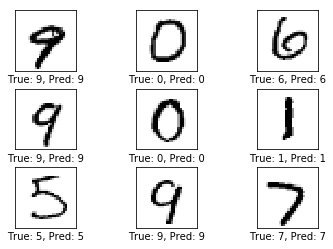

In [32]:
plot_images(images=test_images[9:18], cls_true=cls_test[9:18],cls_pred=pred_kNN[0:9])

In [83]:
pred_adv = []
adv_images = []
correct_cls = 0

for i in range(len(test_images)):
    label = cls_test[i]
    adv_image = sneaky_generate(8,label)
    adv_images.append(adv_image)
    pred_adv.append(predict_noAdv(adv_image))
    if pred_adv[i] == cls_test[i]:
        correct_cls +=1

acc_adv = (correct_cls / (i+1)) * 100
print(acc_adv)        

10.69


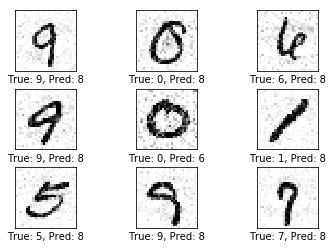

In [66]:
plot_images(images=adv_images[0:9], cls_true=cls_test[9:18],cls_pred=pred_adv[0:9])

In [67]:
pred_adv_kNN = []
adv_images = []
k = 10
for i in range(9,18):
    label = cls_test[i]
    adv_image = sneaky_generate(2,label)
    adv_images.append(adv_image)
    
    label = predict_KNN(k,adv_image)
    img_idx = randImage(train_images, cls_train, label)
    pred_adv_kNN.append(predict_noAdv(train_images[img_idx]))
        

Max iterations reached
Max iterations reached
Max iterations reached
Max iterations reached
Max iterations reached
Max iterations reached
Max iterations reached
Max iterations reached
Max iterations reached


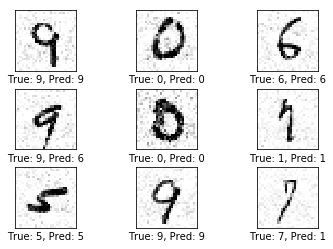

In [68]:
plot_images(images=adv_images[0:9], cls_true=cls_test[9:18],cls_pred=pred_adv_kNN[0:9])

In [76]:
def binary_thresholding(n, m):
    """
    n: int 0-9, the target number to match
    m: index of example image to use (from the test set)
    """
    x = sneaky_generate(n, m)
    x = (x > .5).astype(float)
    return x

In [84]:
pred_adv_BT = []
adv_images = []
k = 10
correct_cls = 0
for i in range(len(test_images)):
    label = cls_test[i]
    x = binary_thresholding(2,label)
    adv_images.append(x)
    pred_adv_BT.append(predict_noAdv(x))
    if pred_adv_BT[i] == cls_test[i]:
        correct_cls +=1
        
acc_adv = (correct_cls / (i+1)) * 100
print(acc_adv)

77.18


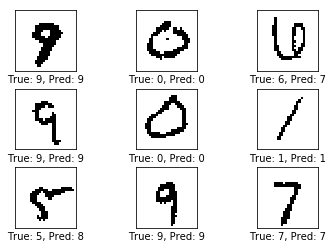

In [79]:
plot_images(images=adv_images[0:9], cls_true=cls_test[9:18],cls_pred=pred_adv_BT[0:9])